# 6211D Assignment 2: Exploring Word Vectors (Max: 30 Points)

Notes to students: 

* This assignment is taken from standford's CS224N, and you can refer to the attached materials from standford for background knowledge.

* Please note that we take plagiarism seriously. Please don't simply take solutions from online, if there is any.

In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# All the dependencies you need, can be installed by running .
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [2]:
# code by HCJ for mounting google drive

from google.colab import drive
drive.mount('/content/drive')

# cd to correct directory (the one containing this notebook)
%cd /content/drive/My\ Drive/4-2/COMP5214/A2
!pwd # check working directory is correct

!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora # added by HCJ

Streaming output truncated to the last 5000 lines.
  inflating: /root/nltk_data/corpora/reuters/training/2231  
  inflating: /root/nltk_data/corpora/reuters/training/2232  
  inflating: /root/nltk_data/corpora/reuters/training/2234  
  inflating: /root/nltk_data/corpora/reuters/training/2236  
  inflating: /root/nltk_data/corpora/reuters/training/2237  
  inflating: /root/nltk_data/corpora/reuters/training/2238  
  inflating: /root/nltk_data/corpora/reuters/training/2239  
  inflating: /root/nltk_data/corpora/reuters/training/2240  
  inflating: /root/nltk_data/corpora/reuters/training/2244  
  inflating: /root/nltk_data/corpora/reuters/training/2246  
  inflating: /root/nltk_data/corpora/reuters/training/2247  
  inflating: /root/nltk_data/corpora/reuters/training/2249  
  inflating: /root/nltk_data/corpora/reuters/training/225  
  inflating: /root/nltk_data/corpora/reuters/training/2251  
  inflating: /root/nltk_data/corpora/reuters/training/2252  
  inflating: /root/nltk_data/corpor

## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *word2vec*. 

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | START | all | that | glitters | is   | not  | gold  | well | ends | END |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| START    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| END      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add START and END tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine START and END tokens encapsulating each document, e.g., "START All that glitters is not gold END", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as *[Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD)* — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds START and END tokens to each of the documents, and lowercases words. You do **not** have perform any other kind of pre-processing.

In [3]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [4]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [5]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    # use nested list comprehension: corpus consists of documents, each of which consist of some set of words.
    # we have to use set() to get DISTINCT words, then transform them back to list and sorted
    corpus_words = sorted(list(set([word for document in corpus for word in document])))
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

In [6]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set(["START", "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", "END"])))
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [7]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    
    # ------------------
    # Write your implementation here.
    # window size n := n preceding and n subsequent words in that document (but not the word itself)
    word2Ind = dict(zip(words, range(num_words)))
    M = np.zeros((num_words, num_words))
    
    # for each document, check each word in sequence (let that word be 'mid_word'). 
    for document in corpus:
        for i in range(len(document)):
            
            mid_word = document[i]
            mid_word_id = word2Ind[mid_word]

            # Get all co-occurring words, and iterate through all 
            # co-occurring words to update co-occurrence matrix
            co_occurring_words = document[max(i-window_size, 0):i] + document[i+1:min(i+window_size+1, len(document))]
            
            for word in co_occurring_words:
                word_id = word2Ind[word]
                M[mid_word_id, word_id] += 1
    
    # ------------------

    return M, word2Ind

In [8]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,],
     [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,],
     [0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,]]
)
word2Ind_ans = {'All': 0, "All's": 1, 'END': 2, 'START': 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [9]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    svd_matrix = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd_matrix.fit_transform(M)
    # ------------------

    print("Done.")
    return M_reduced

In [10]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [11]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    for word in words:
        word_id = word2Ind[word]
        # M_reduced is k-dimensional word embedding. Here we expect k=2
        word_x, word_y = M_reduced[word_id]
        plt.scatter(word_x, word_y, marker='x', color='blue')
        plt.text(word_x, word_y, word, fontsize=12)
    plt.show()
    # ------------------


--------------------------------------------------------------------------------
Outputted Plot:


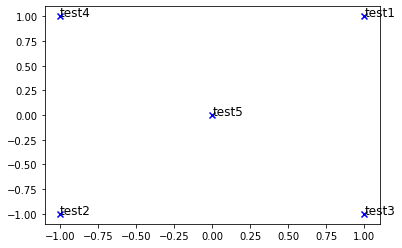

--------------------------------------------------------------------------------


In [12]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4, over the Reuters "crude" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


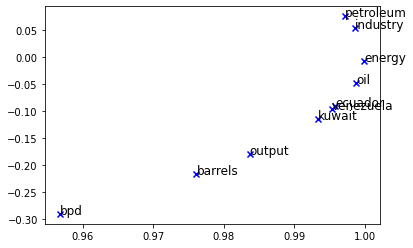

In [13]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>

We can observe 3 clusters: (petroleum, industry), (ecuador, venezuela, kuwait) and (energy, oil). Although we also expect 'bpd', 'barrels' and 'output' to cluster together, since they are all terms that quantify an amount of oil (eg "Ecuador targeting oil output above 500,000 bpd by end of 2021"), in actuality we observe that 'bpd', 'barrels', and 'output' do not form a part of any cluster.

From the plot above we see that countries  (ecuador, venezuela, kuwait) that are major exporters of oil cluster together most closely. This makes sense as these words will tend to be referred to in the same context (as all words are countries), so these countries will share similar co-occurence words in the data, and hence cluster together. However, I would think that 'petroleum' and 'oil' would cluster more closely together as crude oil and petroleum are sometimes used interchangeably.


## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have come into fashion, e.g. word2vec. Here, we shall explore the embeddings produced by word2vec. Please revisit the class notes and lecture slides for more details on the word2vec algorithm. If you're feeling adventurous, challenge yourself and try reading the [original paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Then run the following cells to load the word2vec vectors into memory. **Note**: This might take several minutes.

In [14]:
def load_word2vec(limit=3000000):
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each length 300
    """
    # --- edited by HCJ
    #import gensim.downloader as api
    #wv_from_bin = api.load("word2vec-google-news-300")
    from gensim import models
    path = "./GoogleNews-vectors-negative300.bin"
    wv_from_bin = models.KeyedVectors.load_word2vec_format(path, binary=True, limit=limit)
    # --- end edit by HCJ
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

## <font color="red"> Note: I am running this on Google Colab and hence get an out of memory (RAM) error when I try to download all 3M embeddings and then call the `most_similar()` function. Therefore, to prevent this, I use the solution proposed in [1] and downloaded the word embeddings from source [2] separately, loading the embeddings from [2] with the argument `limit=500000`. This is required since the default `api.load()` command does not support a `limit` argument. Limiting the embeddings we consider to 500,000 isn't a problem since the Google word embeddings are pre-sorted from most to least frequent so it has minimal effect on the `most_similar()` function call.

[1] https://stackoverflow.com/questions/50478046/memory-error-when-using-gensim-for-loading-word2vec

[2] https://github.com/harmanpreet93/load-word2vec-google



In [15]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This may take several minutes
# -----------------------------------
wv_from_bin = load_word2vec()

Loaded vocab size 3000000


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please follow the Piazza instructions, as how to run remotely on Stanford Farmshare machines.**

### Reducing dimensionality of Word2Vec Word Embeddings
Let's directly compare the word2vec embeddings to those of the co-occurrence matrix. Run the following cells to:

1. Put the 3 million word2vec vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 300-dimensional to 2-dimensional.

In [16]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [17]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


### Question 2.1: Word2Vec Plot Analysis [written] (4 points)

Run the cell below to plot the 2D word2vec embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix?

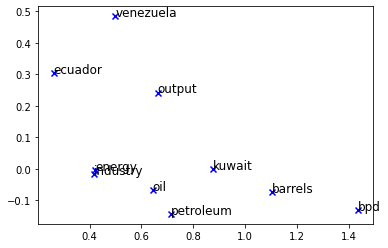

In [18]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)

#### <font color="red">Write your answer here.</font>

The two clusters in 2-dimensional embedding space:

* energy, industry
* oil, petroleum

We normally expect the countries "kuwait", "ecuador", "venezuela" to be clustered together (as in the prior co-occurrence matrix). One of the reasons for this difference is that these words may not appear in the same contexts (in the Reuters corpus, these terms would be mentioned only via their association with oil output) but in the Google embeddings, these terms may appear in contexts such as topics regarding that particular country's finance, environmental policy, politics, history, etc.

Unlike with the window based co-occurence matrix embeddings, these word2vec embeddings do not cluster together countries. Also, the embeddings are closer together in 2d space in the window based co-occurrence matrix, but are further apart for the word2vec embeddings (notice the x-axis scale on both plots.)

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective L1 and L2 Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Polysemous Words (2 points) [code + written] 
Find a [polysemous](https://en.wikipedia.org/wiki/Polysemy) word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from *both* meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous words before you find one. Please state the polysemous word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous words you tried didn't work?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [19]:
# ------------------
# Write your polysemous word exploration code here.
wv_from_bin = load_word2vec(limit=500000)
wv_from_bin.most_similar("fine", topn=10)

# ------------------

Loaded vocab size 500000


[('fines', 0.6188948154449463),
 ('fined', 0.5436111688613892),
 ('fining', 0.4933154582977295),
 ('Fines', 0.4886769652366638),
 ('Fine', 0.47894999384880066),
 ('hefty_fines', 0.47083041071891785),
 ('fines_levied', 0.42544737458229065),
 ('Dri_Roads', 0.42512989044189453),
 ('penalties', 0.4220777451992035),
 ('dandy', 0.42135050892829895)]

#### <font color="red">Write your answer here.</font>
The polysemous word 'fine' may refer to a penalty (as in a parking fine), but it may also be used to describe the quality of something being acceptable ('fine and dandy', 'fine piece of work').

Many polysemous words have top 10 most similar words that don't contain 2 meanings is because words with the same root frequently appear in the top 10. For 'fine' this includes ('fines', 'fined', 'fining', 'fines_levied'). Additionally, some words may be much more common in one particular context than another, so only that meaning is represented in the top 10.

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful". 

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [20]:
# ------------------
# Write your synonym & antonym exploration code here.

w1 = "succeed"
w2 = "triumph"
w3 = "fail"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

# ------------------

Synonyms succeed, triumph have cosine distance: 0.872271865606308
Antonyms succeed, fail have cosine distance: 0.6554767191410065


#### <font color="red">Write your answer here.</font>

Even though some words may be antonyms, they may be used in the same context more frequently than a pair of synonyms, and may be used to make comparisons between two ends of an extreme. Example sentence: "Whether you succeed or fail, I will always support you." Additionally, the word 'triumph' is often used in a slightly different context, since 'triumph' is often applied to "great" or "important" achievements (eg a battle in a war), while 'succeed' and 'fail' are more "everyday" terms ("failed to reach the top shelf", "succeed in changing his mind.")

### Solving Analogies with Word Vectors
Word2Vec vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x", what is x?

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [21]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454),
 ('royal_palace', 0.5087165832519531)]


### Question 2.4: Finding Analogies [code + written]  (2 Points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [22]:
# ------------------
# Write your analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['soft','wet'], negative=['hard']))

# ------------------

[('dry', 0.5441238880157471),
 ('damp', 0.49536949396133423),
 ('Wet', 0.48198872804641724),
 ('soggy', 0.4788076877593994),
 ('moist', 0.4732769727706909),
 ('spongy', 0.45600420236587524),
 ('Soggy', 0.4502944052219391),
 ('softer', 0.4396113157272339),
 ('wet_weather', 0.4377472400665283),
 ('wetness', 0.42803773283958435)]


#### <font color="red">Write your answer here.</font>

The full analogy is soft:hard :: wet:dry. They are both opposites that describe properties of an object.

### Question 2.5: Incorrect Analogy [code + written] (1 point)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [23]:
# ------------------
# Write your incorrect analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['ice', 'rock'], negative=['water'])) # ice:water as rock:magma

# ------------------

[('rockers', 0.4643023610115051),
 ('alt_rock', 0.4591255784034729),
 ('rock_n_roll', 0.45433902740478516),
 ('rock_supergroup', 0.4505819082260132),
 ('punk_rock', 0.4459436535835266),
 ('Indie_rock', 0.4446873366832733),
 ('punk', 0.43966835737228394),
 ('supergroup', 0.43645691871643066),
 ('indie_rock', 0.43593186140060425),
 ('rocks', 0.4242849051952362)]


#### <font color="red">Write your answer here.</font>

The intended analogy is ice:water :: rock:magma (as water is the liquid form of ice, and magma is the liquid form of rock). However, the top-10 most similar list yields words related to 'rock' as in 'rock music' and related subgenres, as opposed to words related to the intended definition (a consolidated mass of stone).

### Question 2.6: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit to our word embeddings.

Run the cell below, to examine (a) which terms are most similar to "woman" and "boss" and most dissimilar to "man", and (b) which terms are most similar to "man" and "boss" and most dissimilar to "woman". What do you find in the top 10?

In [24]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'boss'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'boss'], negative=['woman']))

[('bosses', 0.5522644519805908),
 ('manageress', 0.49151360988616943),
 ('exec', 0.459408164024353),
 ('receptionist', 0.4474116861820221),
 ('Coronation_Street_actress', 0.44275569915771484),
 ('supremo', 0.4409852921962738),
 ('coworker', 0.4398624897003174),
 ('head_honcho', 0.4331406056880951),
 ('husband', 0.4327567517757416),
 ('stepmum', 0.42917579412460327)]

[('supremo', 0.6097397804260254),
 ('head_honcho', 0.5281980037689209),
 ('Boss', 0.5042803287506104),
 ('Caretaker_boss', 0.5035192966461182),
 ('gaffer', 0.5015774965286255),
 ('caretaker_boss', 0.4947904944419861),
 ('bosses', 0.4942495822906494),
 ('hitman', 0.48727428913116455),
 ('honcho', 0.48496079444885254),
 ('boss_Paulo_Sousa', 0.48246514797210693)]


#### <font color="red">Write your answer here.</font>

Let the set of terms most similar to "woman" and "boss" and most dissimilar to "man" be A. They consist of the words 'bosses', 'manageress', 'exec', 'receptionist', 'Coronation_Street_actress' and 'stepmum'. Let the set of terms most similar to "man" and "boss" and most dissimilar to "woman" be B, which consist of the words 'supremo', 'head_honcho', 'Boss', 'Caretaker_boss', 'gaffer'. Unlike B, the set of words in A includes 'receptionist' (clearly not a high-ranking position) and 'Coronation_Street_actress' and 'stepmum' (unrelated to boss whatsoever), whereas the terms in B like 'honcho' and 'gaffer' are slang that also denotes a person in charge of others, and only 'hitman' is not related to boss (but is related to man). This may indicate that when the word embeddings were trained, women were not as frequently discussed as bosses / in positions of seniority. 

### Question 2.7: Independent Analysis of Bias in Word Vectors [code + written]  (2 points)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [25]:
# ------------------
# Write your bias exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['man','doctor'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman','doctor'], negative=['man']))

# ------------------

[('physician', 0.646366536617279),
 ('doctors', 0.5858404636383057),
 ('surgeon', 0.5723941326141357),
 ('dentist', 0.552364706993103),
 ('cardiologist', 0.5413815975189209),
 ('neurologist', 0.5271126627922058),
 ('neurosurgeon', 0.5249835848808289),
 ('urologist', 0.5247740149497986),
 ('Doctor', 0.5240625143051147),
 ('internist', 0.5183224081993103)]

[('gynecologist', 0.7093892097473145),
 ('nurse', 0.647728681564331),
 ('doctors', 0.6471461057662964),
 ('physician', 0.64389967918396),
 ('pediatrician', 0.6249487996101379),
 ('nurse_practitioner', 0.6218314170837402),
 ('obstetrician', 0.6072014570236206),
 ('ob_gyn', 0.5986712574958801),
 ('midwife', 0.5927063226699829),
 ('dermatologist', 0.5739566087722778)]


#### <font color="red">Write your answer here.</font>

Let the set of terms most similar to "woman" and "doctor" and most dissimilar to "man" be A. They consist of the words 'gynecologist', 'nurse', 'pediatrician', 'ob_gyn', 'midwife', 'dermatologist' etc. Let the set of terms most similar to "man" and "doctor" and most dissimilar to "woman" be B, which consist of the words 'surgeon', 'dentist', 'neurologist', 'urologist', etc. Clearly the two sets of words are extremely different, with the set of words in A being specialities that are more commonly attuned to female reproduction and/or the raising of children (midwife, gynecologist, pediatrician) despite the fact that women are just as capable of being doctors in the specialities mentioned in B. Once again, this may indicate that when the word embeddings were trained, the text involved had women in those career positions more frequently.

### Question 2.8: Can you suggest any other method of representing text input other than word2vec? Please briefly explain the technical detail of that method [written]  (6 points)


#### <font color="red">Write your answer here.</font>
A variety of other language modelling techniques exist, such as bag-of-words, contextualised word embeddings, and 1-hot encoding. One such example is TF-IDF (using the bag-of-words approach), which is a commonly adopted and easy-to-implement scheme that attempts to define the importance of a keyword or phrase in a given document. For a given set of documents $D$ (known as a corpus), the $\textbf{term frequency}$ is the number of times the word $t$ appears in a document $d$ is denoted $f_{t,d}$. The $\textbf{inverse document frequency}$, meanwhile, is a measure of how much information that word provides. If $N$ is the total number of documents containing the word $d$ in the corpus and $n_t=|\{d\in D:t\in d\}|$ is the number of documents in the corpus which contains the word $d$, $IDF=log\dfrac{N}{n_t}$. One way to measure TF-IDF is thus $f_{t,d}*log\dfrac{N}{n_t}$. The combination of these two measures tries to limit the effect of rare words (have lower TF) as well as diminish the weights of common words that often provide little actual meaning (eg prepositions such as "to", "and", "the", etc. (have lower IDF)). Therefore, the higher the TF-IDF score, the more relevant that word is in that document, and hence TF-IDF can be used to compute keywords for a given document. TF-IDF can also be used to compute document similarity via Euclidean distance or cosine similarity. However, since Euclidean distance may be sensitive to the lengths of the compared documents, cosine similarity between documents may be a better similarity metric (a smaller angle between documents would imply the documents are more similar).

However TF-IDF assumes term independence, which is not necessarily true, and fails to capture order and grammar within sentences. For example, "It's not as good as before, but still acceptable." vs "It's as good as before, but still not acceptable." have the same TF-IDF reprepresentation, yet the sentiment for the 1st sentence is slightly positive ("still acceptable") whereas the sentiment for the 2nd sentence is negative ("still not acceptable").

Although we can also compute the TF-IDF for n-grams (multiple words in sequence eg "eating food"), this is not scalable and may still miss long-distance dependencies (ex. "eating" and "food" have a long-term dependency in "She ended up eating the moldy piece of bread anyways, because at the end of the day, it was the only food she had left.") N-grams are also heavily dependent on the training corpus and may not generalise well to new text. Also, TF-IDF has a lack of predictive adequacy since the weighting scheme is rather arbitrary (the information about semantic does not increase proportionally to the number of occurrences of that term).

TF-IDF also cannot capture semantic relationships (hypernyms like (car is a vehicle)) and analogies such as man:king :: woman:queen that word embeddings can.



## Assignment 2 Part 2 GNNs

### <font color="red"> Question 2.1.1:
From the lecture notes, it is given that a simple $k$-layer GNN takes a graph $G=(V,E)$ as input and constructs an embedding for each node $v\in V$ from that node $v$'s computation graph, which is defined as the $k$-hop neighbourhood of $v$. In order for the two highlighted red nodes to be distinguished, we need to find the minimum $k$ such that their $k$-hop neighbourhood differs. At $k=1$ and $k=2$ we notice their $k$-hop neighbourhood is still identical, but at $k=3$ they start to be different (in the left graph both nodes 2 hops away from the red node have degree 2, but in the right graph one of the nodes 2 hops away from the red node only has degree 1.) Therefore we need at minimum a 3-layer GNN (3 layers of message passing are needed)

### <font color="red"> Question 2.1.2: 
Source: https://www.baeldung.com/cs/induced-subgraphs

Consider the given graph in the code segment below to be $G=(V,E)$. Let the induced subgraph be $G'=(V',E')$. where the inducing set is defined as $V'\subseteq V$. Choose $V'=V-\{11\}$. Then by definition, the set of edges in $G'$ is $E-\{(4,11)\}$.

A node $u$ is part of a cycle of length exactly $C$ (where $C$ is even) iff we examine its computational graph and observe the same node $v$ twice AND there being two acyclic paths $A$ and $B$ of length exactly $C/2$ from $u$ to $v$ where $A$ and $B$ cannot contain any overlapping nodes besides $u$ and $v$.Therefore, since any $k$-layer GNN with $k<5$ can only compute the $k$-hop neighbourhood of $u$, and $u$ is $C/2=5$ hops away from $v$, it can never find $v$, and thus the GNN will never be able to conclusively determine whether $u$ is part of a length $C=10$ cycle.

See the code segment below this text section for a graph that returns True (on the red coloured node marked $u=2$, we expect to find node $v=7$ twice in its 5-hop computation graph such that there are 2 non-overlapping acyclic paths of length 5 between nodes 2 and 7 (2->1->0->9->8->7) and (2->3->4->5->6>7).

### <font color="red"> Question 2.2.1:
Given a graph $G=(V,E)$:

Let the transition matrix be $P\in \mathbb{R}^{|V|\times |V|}$ where $P_{i,j}=$ probability of going from node $i$ to node $j$. 

Define the binary adjacency matrix $\textbf{A}$ where $\textbf{A}_{i,j}=1$ if there exists an edge from node $i$ to node $j$ and $\textbf{A}_{i,j}=0$ otherwise. Note that $\textbf{A}$ is symmetric if $G$ is undirected.

For a 1-hop uniform random walk, we need to normalise the adjacency matrix by the degree of that node. We can do this by constructing the inverse degree matrix $D^{-1}\in \mathbb{R}^{|V|\times |V|}$ where $D^{-1}_{i,i}=\dfrac{1}{degree(i)}$ $\forall i \in{1,...,|V|}$ and $D^{-1}_{i,j}=0$ $\forall i\neq j$ (i.e. $D$ is a diagonal matrix whose $i$'th elements on the diagonal are the inverse of the degree of node $i$.) Then, after matrix multiplying $D^{-1}$ to $\textbf{A}$, we have $h^{(l+1)}=D^{-1}\textbf{A}h^{(l)}$, therefore the transition matrix is $P=D^{-1}\textbf{A}$ (the columns of $P$ sum to 1.)

### <font color="red"> Question 2.2.2:
Given a graph $G=(V,E)$, the aggregation operation can now be described as:

$h^{(l+1)}=0.5D^{-1}\textbf{A}h^{(l)} + 0.5h^{(l)}=\dfrac{1}{2}(I_{|V|}+D^{-1}A)h^{(l)}$

Therefore the transition matrix $P$ (same definition as in Q2.2.1) can now be described as $P=\dfrac{1}{2}(I_{|V|}+D^{-1}A)$ where $I_{|V|}\in \mathbb{R}^{|V|\times |V|}$ is the identity matrix.

### <font color="red"> Question 2.3.1 + 2.3.2:
Given a graph $G=(V,E)$, the complete learning procedure is:

$h^{(l+1)}=\sigma((\textbf{A}+\textbf{I})h^{(l)})$ where $\textbf{I}\in \mathbb{R}^{|V|\times |V|}$ is the identity matrix and $\textbf{A}$ is the binary adjacency matrix where $\textbf{A}_{i,j}=1$ if there exists an edge from node $i$ to node $j$ and $\textbf{A}_{i,j}=0$ otherwise. 

Define the activation function $\sigma:\mathbb{R}^{|V|}\rightarrow \mathbb{R}^{|V|}$ to be the heaviside step function, i.e.: $\forall k\in \{1,...,|V|\}$, $\sigma(x_k)=1$ if $x_k>0$ and $\sigma(x_k)\leq 0$ otherwise.

The rationale is as follows: At timestep $t=0$, only the source node $v_0$ has input feature 1 i.e. $h_{v_0}^{(0)}=1,h_{j}^{(0)}=0$ $\forall j\neq v_0$. As such, the matrix multiplication takes the $v_0$'th row of $(\textbf{A}+\textbf{I})$ and multiplies it by $h_{v_0}^{(0)}=1$. Then this causes $h_n^{(1)}=1$ for all neighbours $n\in N(v_0)$ of source node $v_0$, as well as $h_{v_0}^{(1)}=1$ itself (since we added the identity matrix). By induction, we can see that the embedding for some node $v\in V$ at the $l$'th layer = 1 iff $v$ is in the $l$-hop neighbourhood of the source node $i$.

Update rule (the idea is, make this node's embedding 1 (active) iff (either this node was previously active ($h_u^{(l)}$), or one of its neighbours is active)):

$h_u^{(l+1)}=max\{h_u^{(l)},m_u^{(l)}\}$

Aggregate rule (the idea is, for all nodes $u$, if we have a neighbour that was activated (has node embedding value 1) then we want this node to have embedding 1 as well.)

$m_u^{(l)}=max\{h_v^{(l)}|v\in N(u)\}$



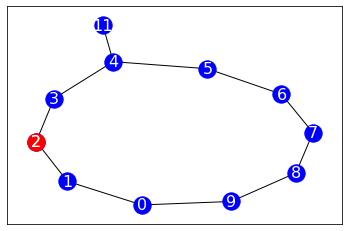

In [26]:
import networkx as nx
G = nx.Graph()
for i in range(1, 11):
    G.add_edge(i%10, (i+1)%10)
G.add_edge(4, 11)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, font_size=16, node_color='blue', font_color='white')
nx.draw_networkx(G.subgraph(2), pos=pos, font_color='white', font_size=16, node_color='red')